In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# some sensible defaults
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

from itertools import accumulate
from functools import wraps

import rnndatasets.sequentialmnist as data

# Activations, with various initialisation

Let's have a look at the histogram of activations per layer in a reasonably deep NN, with a few different inits/activation functions.

First we have to make some neural nets, so let's get that ready to go.

In [2]:
def dense_layer(input_var, size, name):
    # for now we won't bother with a bias
    input_size = input_var.get_shape()[1].value
    weights = tf.get_variable(name+'_W', shape=[input_size, size])
    
    return tf.matmul(input_var, weights)

def deep_net(input_var, layers, size, nonlinearity):
    """Return all activations for a net with `layers` layers each of width `size`"""
    shape = [input_var] + ([size] * layers)
    def layer(a, b):
        return nonlinearity(dense_layer(a, b, '{}'.format(np.random.rand())))
    return list(accumulate(shape, layer))

We also need some initialisers. The first is the 'common heuristic' shot down in Glorot,
$$
    w_{ij} \sim \mathcal{U}\left[\frac{-1}{\sqrt{n}}, \frac{1}{\sqrt{n}} \right]
$$
With $n$ the number of inputs to the layer (number of rows of the current matrix, the way we are handling things above).

In [3]:
def scaled_uniform_init():
    def _init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('I can only handle matrices.')
        scale = 1.0 / np.sqrt(shape[0])
        return np.random.uniform(-scale, scale, shape)
    return _init

And the proposed 'normalized initialisation', aka Glorot Initialisation (which has variance $\frac{1}{n_i + n_j}$
where the $n$ are the size of weight matrix). We will do a version drawn from a normal distribution with this variance as well, because why not.

In [4]:
def glorot_uniform_init():
    def _gu_init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('need shape of length 2')
        scale = np.sqrt(6) / np.sqrt(shape[0] + shape[1])
        return np.random.uniform(-scale, scale, shape)
    return _gu_init

def glorot_normal_init():
    def _gn_init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('need shape of length 2')
        # std dev should be sqrt(variance), variance shuold be 2/(shape[0] + shape[1])
        scale = np.sqrt(2) / np.sqrt(shape[0] + shape[1])
        return np.random.normal(scale=scale, size=shape)

We are also interested in Saxe's orthogonal initialisation. There are a couple of ways to produce a random orthogonal matrix, as far as I can tell precisely zero of them are discussed in the paper. We will do the QR decomposition of a random normal matrix, this is good for reasons (if the diagonal of the R matrix is all positive, then the orthonormal Q would be uniformly distributed in the space of orthogonal matrices, apparently. We will not require this, it should be close enough).

In [5]:
def orthonormal_init():
    def _on_init(shape, dtype=tf.float32):
        if len(shape) != 2:
            raise ValueError('nope')
        mat = np.random.normal(size=shape)
        q, _ = np.linalg.qr(mat)
        return q  # need to be more carfeul about the shapes here
    return _on_init

Now we can make some nets, we will run them on some MNIST digits eventually so let's make them that size.
We also want to play with a few activation functions, so we're going to eventually make something of a grid and let loose on that.

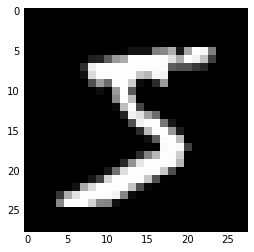

In [6]:
# let's grab a big batch of MNIST digits
images, _ = data.get_data('train', 3000)
images = images.reshape(3000, 28 * 28)
plt.imshow(images[0, ...].reshape((28, 28)))

In [7]:
tf.reset_default_graph()

inputs = tf.constant(images)

activations = {'sigmoid': tf.nn.sigmoid,
               'tanh': tf.nn.tanh,
               'softsign': tf.nn.softsign,
               'relu': tf.nn.relu,
               'elu': tf.nn.elu,
               'softplus': tf.nn.softplus}

depth = 5
width = 1000

nets = {}
with tf.variable_scope('standard', initializer=scaled_uniform_init()):
    nets = {'scaled uniform, '+name: deep_net(inputs, depth, width, nonlin) 
            for name, nonlin in activations.items()}

with tf.variable_scope('glorot_uniform', initializer=glorot_uniform_init()):
    nets.update({'glorot uniform, '+name: deep_net(inputs, depth, width, nonlin) 
                 for name, nonlin in activations.items()})
    
with tf.variable_scope('glorot_normal', initializer=glorot_normal_init()):
    nets.update({'glorot normal, '+name: deep_net(inputs, depth, width, nonlin) 
                 for name, nonlin in activations.items()})

with tf.variable_scope('orthonormal', initializer=orthonormal_init()):
    nets.update({'orthonormal, '+name: deep_net(inputs, depth, width, nonlin) 
                 for name, nonlin in activations.items()})

with tf.variable_scope('uniform_unit', initializer=tf.uniform_unit_scaling_initializer()):
    nets.update({'uniform unit, '+name: deep_net(inputs, depth, width, nonlin) 
                 for name, nonlin in activations.items()})

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [15]:
def plot_activations(name, activations, legend=True):
    plt.title('{}'.format(name))
    for i, act in enumerate(activations[1:]):
        #data, _ = np.histogram(act.mean(axis=0), bins=50)
        #plt.plot(data, label='Layer {}'.format(i+1))
        plt.hist(act.mean(axis=0), label='Layer {}'.format(i+1), histtype='step',
                 bins=100, normed=False)
        if legend:
            plt.legend()

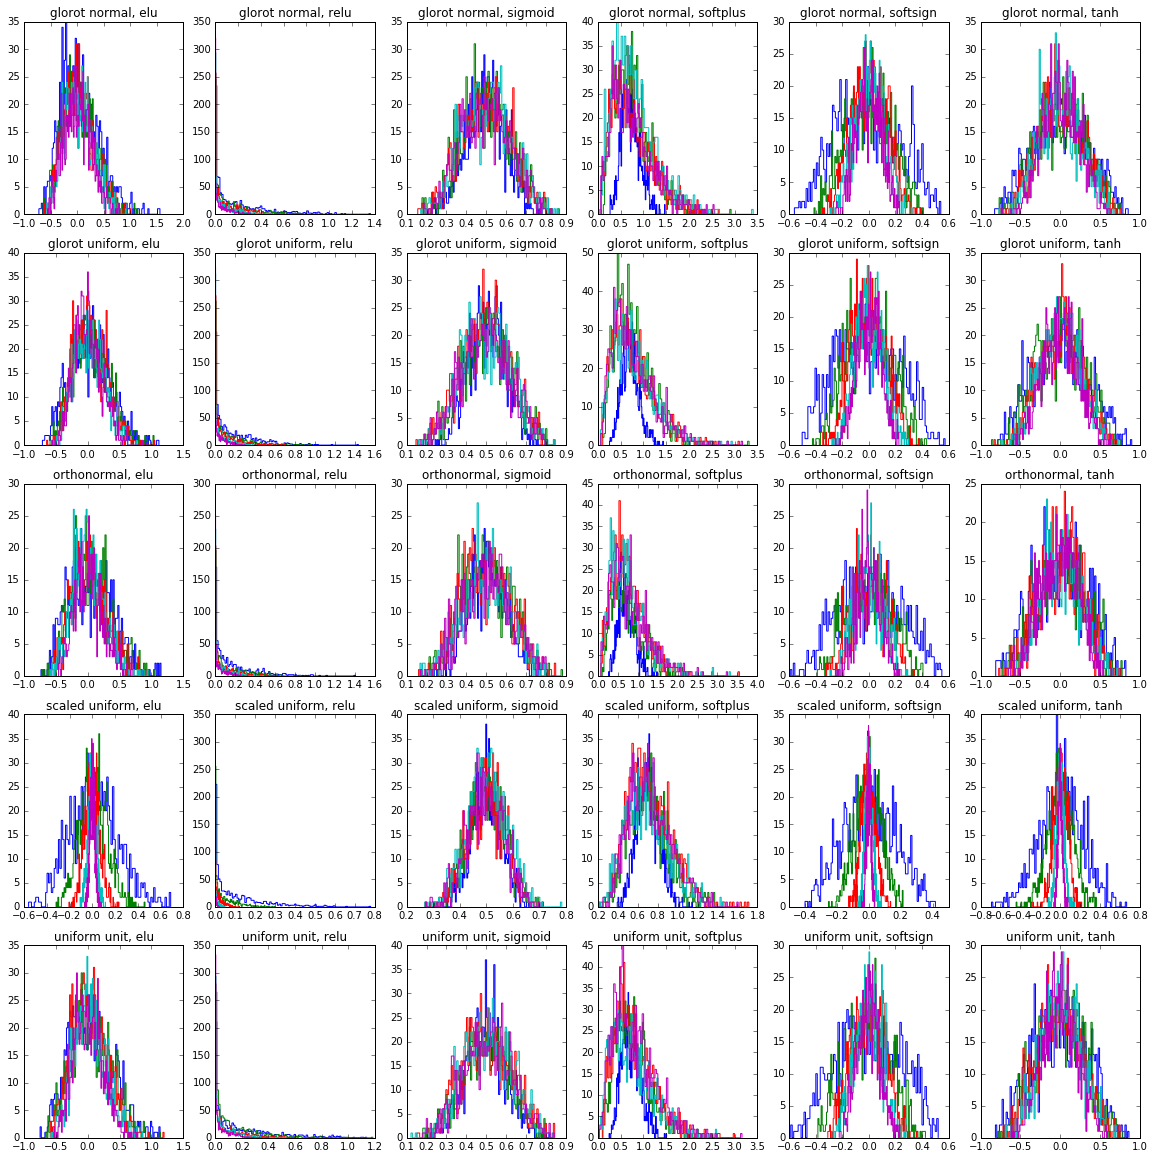

In [16]:
plt.figure(figsize=(20, 20))
i = 0
for name, activations in sorted(list(nets.items())):
    batch_acts = sess.run(activations)
    plt.subplot(5, 6, i+1)
    i += 1
    plot_activations(name, batch_acts, legend=False)

We could do the same thing with the gradients of the output of the net wrt. the layer activations (how does this evenmake sense? why does tensorflow give me a vector? even if it does the labels don't)

In [17]:
def get_grad(acts):
    #return [tf.gradients(b, a)[0] for a, b in zip(acts, acts[1:])]
    return [tf.gradients(acts[-1], a)[0] for a in acts[:-1]]
    
grads = {name + ' grad': get_grad(acts) for name, acts in nets.items()}

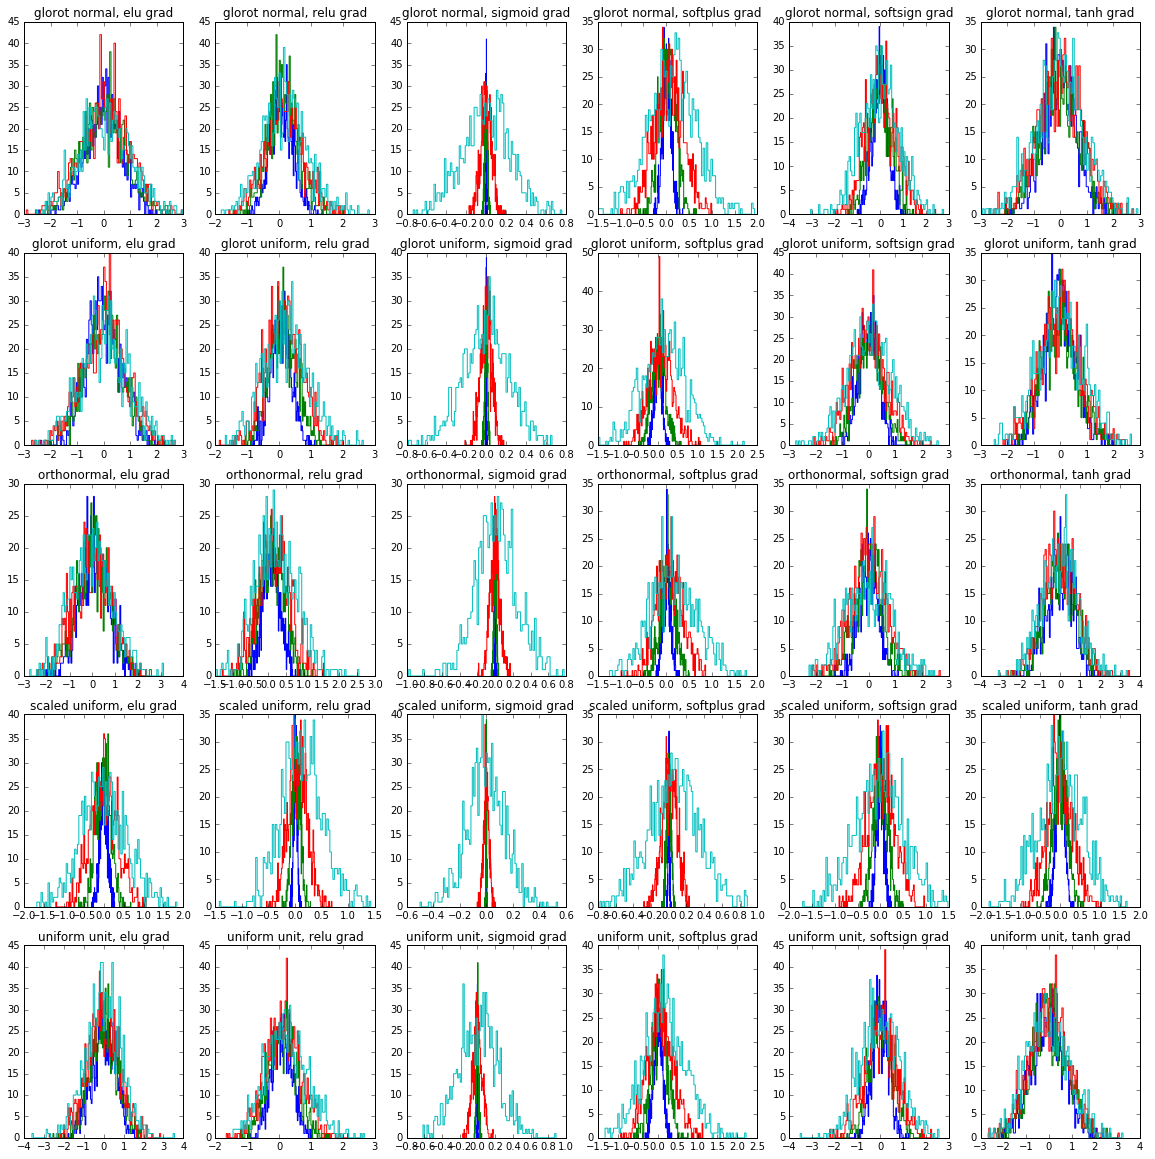

In [18]:
plt.figure(figsize=(20, 20))
i = 0
for name, gradients in sorted(list(grads.items())):
    batch_grads = sess.run(gradients)
    plt.subplot(5, 6, i+1)
    i += 1
    plot_activations(name, batch_grads, legend=False)

Make the relus bigger

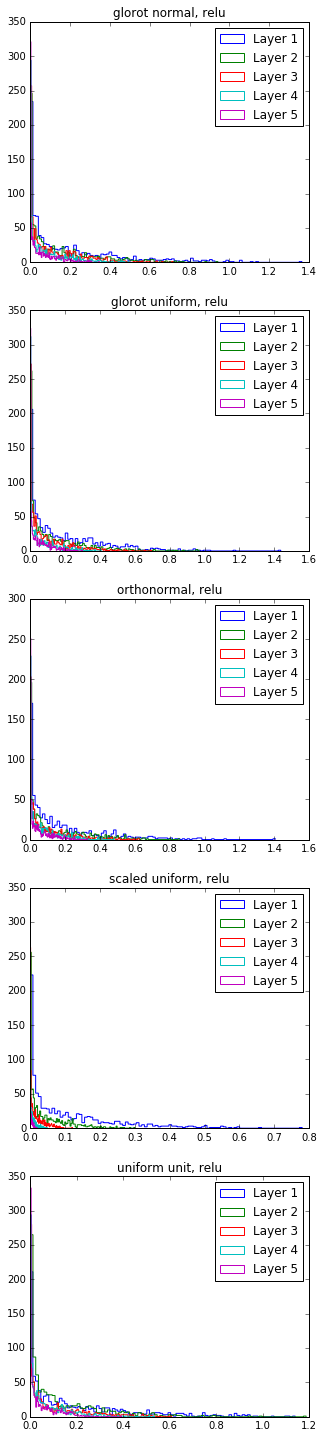

In [20]:
plt.figure(figsize=(5, 25))
i = 0
for name, activations in sorted(list(nets.items())):
    if 'relu' in name:
        batch_acts = sess.run(activations)
        plt.subplot(5, 1, i+1)
        i += 1
        plot_activations(name, batch_acts, legend=True)